## Imports

In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array
from MDAnalysis import units
from MDAnalysis.analysis import rdf
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB
from openmm.unit import kelvin, bar, litre, kilojoule_per_mole, mole, nanometer, angstrom, kilocalorie_per_mole
from openmm.unit import Quantity, Unit
import quantities
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from pymbar import timeseries
from MDAnalysis.analysis import density
from tqdm import tqdm


/tmp/ipykernel_7840/123884183.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*               

## Loading data and creating atom group of ions

In [2]:
u = mda.Universe('md.gro', 'md.xtc')
u.transfer_to_memory()
ions= u.select_atoms('resname SOD CLA')

u1 = mda.Universe('mdr1.gro', 'mdr1.xtc')
u1.transfer_to_memory()
ions1= u1.select_atoms('resname SOD CLA')

u2 = mda.Universe('mdr2.gro', 'mdr2.xtc')
u2.transfer_to_memory()
ions2= u2.select_atoms('resname SOD CLA')

u3 = mda.Universe('mdr3.gro', 'mdr3.xtc')
u3.transfer_to_memory()
ions3= u3.select_atoms('resname SOD CLA')




## Function for calculating osmotic values:

In [9]:
def SPW_analysis(u, ions, repnum):

## loading data
        
    if repnum == 0:
        print("Data for original run")
    else:
        print("Data for replicate #",repnum)

    box_size = u.dimensions[:3] * angstrom
    wall1=box_size[2]/2-24*angstrom
    wall2=box_size[2]/2+24*angstrom
    R = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA # gas constant

    box_x = box_size[0]
    box_y = box_size[1]

    A_box = box_x * box_y 

    dim_mem = wall2-wall1
    V_mem = A_box * dim_mem
    #print(V_mem)

    n_part = 65
    M = n_part / (V_mem * AVOGADRO_CONSTANT_NA)
    M = M.in_units_of(mole / litre)
    #print(M)

## calculation of osmotic values

    def osmotic_values(mean_force_wall, molarity :Quantity, vant_hoff : int=2, T=300*kelvin, cross_sectional_area : Quantity=48*48 * angstrom**2 ):
        osm_press=mean_force_wall/cross_sectional_area
        osm_bar = osm_press.in_units_of(bar / mole)
        osm_bar = osm_bar/AVOGADRO_CONSTANT_NA
        print(f"Osmotic Pressure Observed:", osm_bar)
        osm_press_ideal=vant_hoff*molarity*R*T
        osm_press_ideal=osm_press_ideal.in_units_of(bar)
        print(f"Osmotic Pressure Ideal:", osm_press_ideal)
        osm_coeff=osm_bar/osm_press_ideal
        print(f"Osmotic Coefficient:", osm_coeff)
        op_error=(abs(osm_bar-osm_press_ideal)/osm_press_ideal)*100
        print(f"Osmotic Pressure Error:", op_error)
        oc_error=(abs(osm_coeff-0.94)/osm_coeff)*100
        print(f"Osmotic Coefficient Error:", oc_error)
        return osm_bar,osm_coeff

    def osmotic_values_noprint(mean_force_wall, molarity=M, vant_hoff:int=2, T=300*kelvin, cross_sectional_area:Quantity=(wall1*wall2)):
        osm_press=mean_force_wall/cross_sectional_area
        osm_bar = osm_press.in_units_of(bar / mole)
        osm_bar = osm_bar/AVOGADRO_CONSTANT_NA
        osm_press_ideal=vant_hoff*molarity*R*T
        osm_press_ideal=osm_press_ideal.in_units_of(bar)
        osm_coeff=osm_bar/osm_press_ideal
        op_error=(abs(osm_bar-osm_press_ideal)/osm_press_ideal)*100
        return osm_bar,osm_coeff

    def calculate_net_force(z_values : np.ndarray[float], zwall : float, k : float) -> float:
        return k * abs(z_values - zwall).sum()

## calculation of mean force

    k_nm = 4184 * kilojoule_per_mole / nanometer**2
    k = k_nm.in_units_of(kilojoule_per_mole / angstrom**2)

    walls_z_pos = np.array([48, 96]) * angstrom
    forces_at_ts = {
        48 : [],
        96 : []
    }

    for _ in u.trajectory:
        ions_z = ions.positions[:,2]*angstrom
        force_48 = calculate_net_force(
            z_values=ions_z[ions_z < wall1],
            zwall=wall1,
            k=k
        )
        forces_at_ts[48].append(force_48)

        force_96 = calculate_net_force(
            z_values=ions_z[ions_z > wall2],
            zwall=wall2,
            k=k
        )
        forces_at_ts[96].append(force_96)

    mean_forces = {
        abs_wall_z : sum(force_list, start=0*(kilojoule_per_mole / angstrom)) / len(u.trajectory)
            for abs_wall_z, force_list in forces_at_ts.items()
    }

    #print('mean forces =', mean_forces)



## calling calculation of osmotic values
    
    for wall_z_val, mF in mean_forces.items():
        #print(wall_z_val)
        o = osmotic_values(mF, molarity=M, cross_sectional_area=A_box)


    # print("\nAverage between 2 walls: ")
    # av_mF=(mean_forces[48]+mean_forces[96])/2
    # o = osmotic_values(av_mF, molarity=M, cross_sectional_area=A_box)

## number of ions per z coordinate (both observed through the system and outside the walls)
    ions_at_48=[]
    ions_at_96=[]
    zpositions=[]

    for _ in u.trajectory:
        ions_z = ions.positions[:,2]*angstrom
        zpositions.append(ions_z)
        z_values48=ions_z[ions_z < wall1]
        z_values96=ions_z[ions_z > wall2]
        ions_at_48.append(z_values48)
        ions_at_96.append(z_values96)

    # plt.hist(ions_at_48,bins='auto',edgecolor='blue')
    # plt.xlabel('z coordinates (A)')
    # plt.ylabel('Number of Ions')
    # plt.title('Number of ions outside of wall at 4.8 nm')
    # plt.axis([47, 48, 0, 2.5])
    # # Display the plot
    # plt.grid(True)
    # plt.show()

    # plt.hist(ions_at_96,bins='auto',edgecolor='red')
    # plt.xlabel('z coordinates (A)')
    # plt.ylabel('Number of Ions')
    # plt.title('Number of ions outside of wall at 9.6 nm')
    # plt.axis([96, 97, 0, 2.5])
    # plt.grid(True)
    # plt.show()

    # plt.hist(zpositions,bins='auto',edgecolor='green')
    # plt.xlabel('z coordinates (A)')
    # plt.ylabel('Number of Ions')
    # plt.title('Number of ions per z coordinate')
    # plt.grid(True)
    # plt.show()

## plotting force vs time

    list48=forces_at_ts[48]
    list96=forces_at_ts[96]
    f48=[]
    f96=[]
    time=[]
    for i,ts in enumerate(u.trajectory):
        time.append(u.trajectory.time)
        val48=list48[i]
        val96=list96[i]
        f48.append(val48.item())
        f96.append(val96.item())

    # plt.plot(time,f96, color='r', label='9.6 nm')
    # plt.plot(time,f48, color='g', label='4.8 nm')
    # plt.ylabel("Forces")
    # plt.xlabel("Time")
    # plt.title("Forces vs time")
    # plt.legend()
    # plt.show()

    print("----------------------------------------------------------------")

## calculation of autocorrelation function and plot of uncorrelated samples
    
    fts48=np.array(f48)
    fts96=np.array(f96)

    nskip=100
    t0, g, Neff_max = timeseries.detect_equilibration(fts48,nskip=nskip) # compute indices of uncorrelated timeseries
    fts48_equil = fts48[t0:]
    indices48 = timeseries.subsample_correlated_data(fts48_equil, g=g)
    fts48_s = fts48_equil[indices48]

    indt48=[]
    for i in indices48:
        indt48.append(time[i])

    print("---Wall 4.8 nm---")
    print('t0 =', t0,' g =',g,' Neff_max =', Neff_max)
    #mean of full time series
    meanf48=np.mean(f48)
    meanf48=meanf48*kilojoule_per_mole/angstrom
    #stdev of the full timeseries devided by sqrt of the number of effective samples -1
    sterrf48=np.std(f48)/np.sqrt(len(indt48)-1)
    # squared_diff48 = (f48*kilojoule_per_mole/angstrom - meanf48) ** 2
    varf48 = sterrf48**2

    print(f"Mean = {meanf48}, std error = {sterrf48}, variance = {varf48}",'\n')

    # plt.plot(time,f48)
    # plt.scatter(indt48, fts48_s, color='m', marker='o')
    # plt.ylabel("Forces")
    # plt.xlabel("Time")
    # plt.title("Forces at 4.8 nm Wall")
    # plt.show()

    t0, g, Neff_max = timeseries.detect_equilibration(fts96,nskip=nskip) # compute indices of uncorrelated timeseries
    fts96_equil = fts96[t0:]
    indices96 = timeseries.subsample_correlated_data(fts96_equil, g=g)
    fts96_s = fts96_equil[indices96]

    indt96=[]
    for i in indices96:
        indt96.append(time[i])


    print("---Wall 9.6 nm---")
    #statistical values of t0 (time after equil), g (statistical efficiency/correlation time of equil data), Neff (# of eff samples)
    print('t0 =', t0,' g =',g,' Neff_max =', Neff_max)
    #mean of full time series
    meanf96=np.mean(f96)
    meanf96=meanf96*mF.unit
    #stdev of the full timeseries devided by sqrt of the number of effective samples -1
    sterrf96=np.std(f96)/np.sqrt(len(indt96)-1)
    # squared_diff96 = (f96*kilojoule_per_mole/angstrom - meanf96) ** 2
    varf96 = sterrf96**2
    print(f"Mean = {meanf96}, std error = {sterrf96}, variance = {varf96}",'\n')

    # plt.plot(time, f96, c='g')
    # plt.scatter(indt96, fts96_s, color='m', marker='o')
    # plt.ylabel("Forces")
    # plt.xlabel("Time")
    # plt.title("Forces at 9.6 nm Wall")
    # plt.show()

    def comb_SEM(sem1,sem2,n1,n2):
        """
        Calculate the standard error of the mean for combined data.

        Args:
        sem1 (float): Standard error of the mean for the first set of data.
        sem2 (float): Standard error of the mean for the second set of data.
        n1 (int): Sample size of the first set of data.
        n2 (int): Sample size of the second set of data.

        Returns:
        float: The standard error of the mean for combined data.
        """
        combined_sem = np.sqrt((sem1**2 * (n1 - 1) + sem2**2 * (n2 - 1)) / (n1 + n2 - 2))
        return combined_sem
    
    print("---Statistical Analysis results---")
    #average between two walls
    statmeanF=(meanf48+meanf96)/2
    errvar=np.sqrt((varf48+varf96)/2)
    comberror=comb_SEM(sterrf48,sterrf96,len(indt48),len(indt96))
    print(f'Mean force between two walls: {statmeanF}')
    print(f'Mean std error between two walls: +/-{comberror} or {errvar}')
    
    errvar=errvar*(kilojoule_per_mole/angstrom)
    print("------------------------------------------------------------------------")

    print(f"FINAL STATISTICAL RESULTS:")
    
    print("------------------------------------------------------------------------")   
    #calculation of osmotic values from statistical mean and std error
    osmval = osmotic_values_noprint(statmeanF, molarity=M, cross_sectional_area=A_box) 
    osmerr = osmotic_values_noprint(errvar, molarity=M, cross_sectional_area=A_box)

    print(f"Osmotic Pressure = {osmval[0]} +/- {osmerr[0]} \nOsmotic Coefficient = {osmval[1]} +/- {osmerr[1]}")

    return osmval[0],osmerr[0],M

In [10]:
original=SPW_analysis(u,ions,0)


Data for original run
Osmotic Pressure Observed: 53.588458676653325 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 1.1006445523117965
Osmotic Pressure Error: 10.064455231179643
Osmotic Coefficient Error: 14.5954978811623
Osmotic Pressure Observed: 45.42034641513391 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.9328810359629068
Osmotic Pressure Error: 6.711896403709323
Osmotic Coefficient Error: 0.7631159561245681
----------------------------------------------------------------
---Wall 4.8 nm---
t0 = 0  g = 2.5294485  Neff_max = 396.1338
Mean = 7.4354052386822165 kJ/(A mol), std error = 0.4959716177125515, variance = 0.24598784557640532 

---Wall 9.6 nm---
t0 = 0  g = 1.4182512  Neff_max = 706.5039
Mean = 6.302078656816817 kJ/(A mol), std error = 0.3286609869085206, variance = 0.10801804431568274 

---Statistical Analysis results---
Mean force between two walls: 6.868741947749516 kJ/(A mol)
Mean std error between two walls: +/-0.39694

In [11]:
r1=SPW_analysis(u1,ions1,1)

Data for replicate # 1
Osmotic Pressure Observed: 51.7930597418564 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 1.0637691484354848
Osmotic Pressure Error: 6.376914843548469
Osmotic Coefficient Error: 11.634963151311126
Osmotic Pressure Observed: 49.69510731592482 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 1.0206796480909468
Osmotic Pressure Error: 2.067964809094671
Osmotic Coefficient Error: 7.90450247948492
----------------------------------------------------------------
---Wall 4.8 nm---
t0 = 200  g = 1.3233827  Neff_max = 606.0227
Mean = 7.186293415446858 kJ/(A mol), std error = 0.3878772299720505, variance = 0.15044874553079093 

---Wall 9.6 nm---
t0 = 0  g = 1.9389422  Neff_max = 516.7766
Mean = 6.895202258069081 kJ/(A mol), std error = 0.4175203759999675, variance = 0.17432326437515425 

---Statistical Analysis results---
Mean force between two walls: 7.040747836757969 kJ/(A mol)
Mean std error between two walls: +/-0.401806

In [12]:
r2=SPW_analysis(u2,ions2,2)

Data for replicate # 2
Osmotic Pressure Observed: 45.253006570587836 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 0.9294440703767967
Osmotic Pressure Error: 7.055592962320338
Osmotic Coefficient Error: 1.1357251027406
Osmotic Pressure Observed: 52.00873597710481 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 1.0681988872122916
Osmotic Pressure Error: 6.819888721229147
Osmotic Coefficient Error: 12.001406175104327
----------------------------------------------------------------
---Wall 4.8 nm---
t0 = 0  g = 2.0500963  Neff_max = 488.75754
Mean = 6.278860232784794 kJ/(A mol), std error = 0.40257657737968494, variance = 0.16206790065474147 

---Wall 9.6 nm---
t0 = 0  g = 1.2235341  Neff_max = 818.93915
Mean = 7.21621851963954 kJ/(A mol), std error = 0.32680712816937046, variance = 0.10680289902231134 

---Statistical Analysis results---
Mean force between two walls: 6.747539376212167 kJ/(A mol)
Mean std error between two walls: +/-0.3570

In [13]:
r3=SPW_analysis(u3,ions3,3)

Data for replicate # 3
Osmotic Pressure Observed: 49.256554145886106 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 1.0116722765519615
Osmotic Pressure Error: 1.167227655196132
Osmotic Coefficient Error: 7.084535003394479
Osmotic Pressure Observed: 49.270374064924496 bar
Osmotic Pressure Ideal: 48.688251410590276 bar
Osmotic Coefficient: 1.0119561215995447
Osmotic Pressure Error: 1.195612159954469
Osmotic Coefficient Error: 7.110596997605747
----------------------------------------------------------------
---Wall 4.8 nm---
t0 = 0  g = 1.2679571  Neff_max = 790.24756
Mean = 6.834352951735765 kJ/(A mol), std error = 0.3352509847419536, variance = 0.1123932227704496 

---Wall 9.6 nm---
t0 = 0  g = 2.4227986  Neff_max = 413.57132
Mean = 6.836270467203695 kJ/(A mol), std error = 0.4661626047847726, variance = 0.21730757409972412 

---Statistical Analysis results---
Mean force between two walls: 6.83531170946973 kJ/(A mol)
Mean std error between two walls: +/-0.38520

## Stdev between replicates

In [ ]:
meanFs=[mF_r1,mF_r2,mF_r3]
#rep_stdev=np.std(meanFs)
means = np.mean(meanFs, axis=-1)  # Step 1: Calculate mean of each set of replicates
std_devs = np.std(meanFs, axis=-1)  # Step 2: Calculate standard deviation of each set
n = len(meanFs)  # Number of replicates
ses = std_devs / np.sqrt(n)  # Step 3: Calculate standard error for each set
print(ses)

0.07094055576647088


### Density profiles using GROMACS

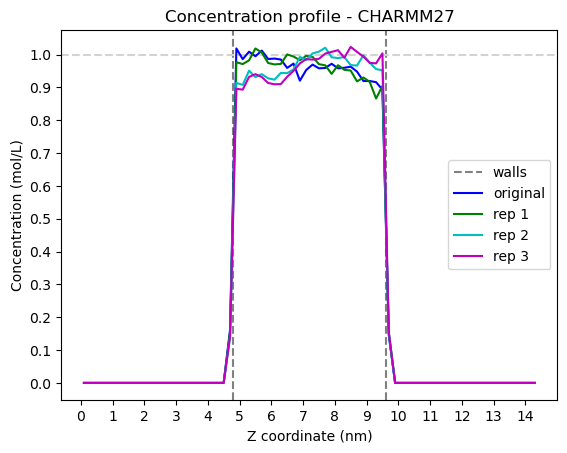

In [ ]:
x,y = np.loadtxt("density_original.xvg",comments=["@", "#"],unpack=True)
y=(y/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y=y.in_units_of(mole/litre)/2
x1,y1 = np.loadtxt("dens_r1.xvg",comments=["@", "#"],unpack=True)
y1=(y1/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y1=y1.in_units_of(mole/litre)/2
x2,y2 = np.loadtxt("dens_r2.xvg",comments=["@", "#"],unpack=True)
y2=(y2/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y2=y2.in_units_of(mole/litre)/2
x3,y3 = np.loadtxt("dens_r3.xvg",comments=["@", "#"],unpack=True)
y3=(y3/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y3=y3.in_units_of(mole/litre)/2
plt.axvline(x = 4.8, color = 'gray', label = 'walls', linestyle = 'dashed')
plt.axvline(x = 9.6, color = 'gray', linestyle = 'dashed')
plt.axhline(y = 1, color = 'lightgray', linestyle = 'dashed')
plt.plot(x,y, c='b', label='original')
plt.plot(x1,y1, c='g', label='rep 1')
plt.plot(x2,y2, c='c', label='rep 2')
plt.plot(x3,y3, c='m', label='rep 3')
plt.xlabel("Z coordinate (nm)")
plt.ylabel("Concentration (mol/L)")
plt.xticks(np.arange(0, 14.4, 1.0))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Concentration profile - CHARMM27')
plt.legend()
#plt.savefig("volume.png", format="png", dpi=300)
plt.show()

## Density profiles using MDanalysis

In [ ]:
def density_profile(universe, atom_group, bin_width=0.5, dim='z', method='atom', frameby=1):
    '''Calculate the partial density across the box'''

    if isinstance(atom_group, str): # if provided selection language, make AtomGroup
        ag = universe.select_atoms(atom_group)
    else: # else assume input is AtomGroup
        ag = atom_group

    print(f'\nCalculating the partial density profile of {atom_group} in the {dim} dimension...')

    dims = {'x': 0, 'y': 1, 'z': 2}
    d = dims[dim]
    box = universe.dimensions[d]

    n_bins = int(box / bin_width)
    bins = np.linspace(0, box, num=n_bins)

    counts = np.zeros(n_bins-1)
        
    if len(universe.trajectory) == 0:
        for b in tqdm(range(n_bins-1)):
            lb = bins[b]
            ub = bins[b+1]
            bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)
            if method in ['atom', 'atoms', 'all']:
                counts[b] += len(bin_atoms)
            elif method in ['molecule', 'mol', 'residue', 'res']: 
                counts[b] += bin_atoms.n_residues
            elif method in ['mass', 'mass density']:
                box_dims = [box[i] for i in range(3) if i != d]
                dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                mass = bin_atoms.masses.sum() / 6.022 / 10**23
                counts[b] += mass / dV
    else:
        for ts in tqdm(universe.trajectory[::frameby]):
            for b in range(n_bins-1):
                lb = bins[b]
                ub = bins[b+1]
                bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)

                if method in ['atom', 'atoms', 'all', 'number']:
                    counts[b] += len(bin_atoms)                 
                elif method in ['molecule', 'mol', 'residue', 'res']: 
                    counts[b] += bin_atoms.n_residues
                elif method in ['mass', 'mass density']:
                    box_dims = [box[i] for i in range(3) if i != d]
                    dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                    mass = bin_atoms.masses.sum() / 6.022 / 10**23
                    counts[b] += mass / dV

        counts = counts / len(universe.trajectory[::frameby])

    return bins, counts

In [ ]:
nbins,ncounts=density_profile(u,ions,2)
nbins1,ncounts1=density_profile(u1,ions1,2)
nbins2,ncounts2=density_profile(u2,ions2,2)
nbins3,ncounts3=density_profile(u3,ions3,2)


Calculating the partial density profile of <AtomGroup [<Atom 11101: SOD of type NA of resname SOD, resid 1 and segid SYSTEM>, <Atom 11102: SOD of type NA of resname SOD, resid 2 and segid SYSTEM>, <Atom 11103: SOD of type NA of resname SOD, resid 3 and segid SYSTEM>, ..., <Atom 11228: CLA of type CL of resname CLA, resid 63 and segid SYSTEM>, <Atom 11229: CLA of type CL of resname CLA, resid 64 and segid SYSTEM>, <Atom 11230: CLA of type CL of resname CLA, resid 65 and segid SYSTEM>]> in the z dimension...


100%|██████████| 1001/1001 [02:41<00:00,  6.20it/s]



Calculating the partial density profile of <AtomGroup [<Atom 11101: SOD of type NA of resname SOD, resid 1 and segid SYSTEM>, <Atom 11102: SOD of type NA of resname SOD, resid 2 and segid SYSTEM>, <Atom 11103: SOD of type NA of resname SOD, resid 3 and segid SYSTEM>, ..., <Atom 11228: CLA of type CL of resname CLA, resid 63 and segid SYSTEM>, <Atom 11229: CLA of type CL of resname CLA, resid 64 and segid SYSTEM>, <Atom 11230: CLA of type CL of resname CLA, resid 65 and segid SYSTEM>]> in the z dimension...


100%|██████████| 1001/1001 [02:33<00:00,  6.52it/s]



Calculating the partial density profile of <AtomGroup [<Atom 11101: SOD of type NA of resname SOD, resid 1 and segid SYSTEM>, <Atom 11102: SOD of type NA of resname SOD, resid 2 and segid SYSTEM>, <Atom 11103: SOD of type NA of resname SOD, resid 3 and segid SYSTEM>, ..., <Atom 11228: CLA of type CL of resname CLA, resid 63 and segid SYSTEM>, <Atom 11229: CLA of type CL of resname CLA, resid 64 and segid SYSTEM>, <Atom 11230: CLA of type CL of resname CLA, resid 65 and segid SYSTEM>]> in the z dimension...


100%|██████████| 1001/1001 [02:35<00:00,  6.43it/s]



Calculating the partial density profile of <AtomGroup [<Atom 11101: SOD of type NA of resname SOD, resid 1 and segid SYSTEM>, <Atom 11102: SOD of type NA of resname SOD, resid 2 and segid SYSTEM>, <Atom 11103: SOD of type NA of resname SOD, resid 3 and segid SYSTEM>, ..., <Atom 11228: CLA of type CL of resname CLA, resid 63 and segid SYSTEM>, <Atom 11229: CLA of type CL of resname CLA, resid 64 and segid SYSTEM>, <Atom 11230: CLA of type CL of resname CLA, resid 65 and segid SYSTEM>]> in the z dimension...


100%|██████████| 1001/1001 [02:42<00:00,  6.15it/s]


### Density plots

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.50780948
 1.021722   1.00179734 1.01884998 1.00287435 1.03159458 0.97433363
 0.99910482 1.00125884 0.96266604 0.96320454 0.94974194 0.96912809
 0.97576964 0.96984609 0.97289762 0.97343612 0.9829497  0.96876908
 0.96158903 0.9447159  0.9195857  0.92856077 0.90935412 0.4469585
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ] mol/L


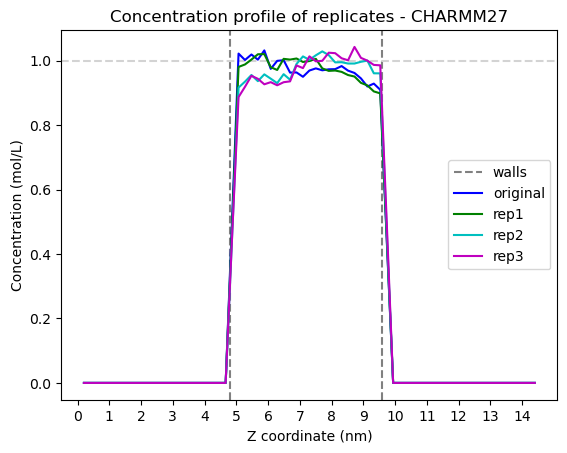

In [ ]:
nb=144.4/72
volbin=48*48*nb*angstrom**3
counts=(ncounts/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
counts1=(ncounts1/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
counts2=(ncounts2/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
counts3=(ncounts3/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2

bins=nbins/10
bins1=nbins1/10
bins2=nbins2/10
bins3=nbins3/10

print(counts)

plt.axvline(x = 4.8, color = 'gray', label = 'walls', linestyle = 'dashed')
plt.axvline(x = 9.6, color = 'gray', linestyle = 'dashed')
plt.axhline(y = 1, color = 'lightgray', linestyle = 'dashed')
plt.plot(bins[1:],counts, c='b', label='original')
plt.plot(bins1[1:],counts1, c='g', label='rep1')
plt.plot(bins2[1:],counts2, c='c', label='rep2')
plt.plot(bins3[1:],counts3, c='m', label='rep3')

plt.xlabel("Z coordinate (nm)")
plt.ylabel("Concentration (mol/L)")
plt.xticks(np.arange(0, 14.4, 1))
plt.title("Concentration profile of replicates - CHARMM27")
plt.legend()
plt.show()